In [1]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA
using Random
using NNlib

In [8]:
OUT_DIR = "locaTE_output/"
TE = npzread(joinpath(OUT_DIR, "TE.npy"));
L = sparse(npzread(joinpath(OUT_DIR, "L.npy")));
qnorm(x, q) = x ./ quantile(vec(x), q);

In [9]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(zeros(size(TE, 2)), 1, size(TE, 1))'), 
                     16; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 5_000, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


In [10]:
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);
npzwrite(joinpath(OUT_DIR, "U.npy"), U)
npzwrite(joinpath(OUT_DIR, "V.npy"), V)

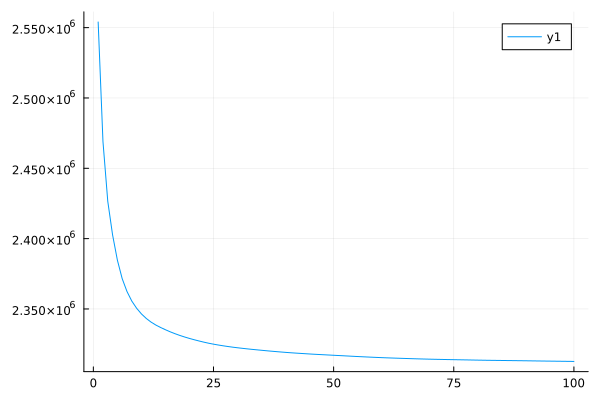

In [11]:
plot(trace)